# Classifiers
Exploring different classifiers.

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import numpy as np
import tensorflow as tf
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy',
           keras.metrics.TruePositives(),
           keras.metrics.FalsePositives(),
           keras.metrics.TrueNegatives(),
           keras.metrics.FalseNegatives()]

In [2]:
np.random.seed(4)
tf.random.set_seed(2)

This is the original author's code, just copied into separate cells of this jupyter notebook:

In [3]:
def get_busy_vs_relax_timeframes(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)
        try:
            tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 1))
            tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 0))
        except ValueError:
            continue
#             print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [4]:
def get_engagement_increase_vs_decrease_timeframes(path, ident, seconds):
    """Returns raw data from either engagement 'increase' or 'decrease' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds * samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### engagement increase / decrease
        if task_num_table == 0:
            continue
        mid = int((relax_n[task_num_table][0] + relax_n[task_num_table][1])/2)
        length = int(samp_rate*30)
        for j in range(10):
            new_end = int(mid-j*samp_rate)

            new_start2 = int(mid+j*samp_rate)

            dataextract_decrease = dataextractor.DataExtractor(data[0][new_end - length:new_end],
                                                               data[1][new_end-length:new_end],
                                                               samp_rate)

            dataextract_increase = dataextractor.DataExtractor(data[0][new_start2: new_start2 + length],
                                                               data[1][new_start2: new_start2 + length], samp_rate)

            try:
                tasks_data = np.vstack((tasks_data, dataextract_increase.y))
                tasks_y = np.vstack((tasks_y, 1))
                tasks_data = np.vstack((tasks_data, dataextract_decrease.y))
                tasks_y = np.vstack((tasks_y, 0))
            except ValueError:
                print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [5]:
def get_task_complexities_timeframes(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [6]:
def get_TLX_timeframes(path, ident, seconds):
    """Returns raw data along with task load index class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task load index
        if cog_res['task_complexity'][task_num_table] == 'medium' or cog_res['task_label'][task_num_table] != 'PT':
            continue
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, cog_res['task_load_index'][task_num_table]))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [7]:
def get_data_from_idents(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    for i in idents:
        x, y = get_busy_vs_relax_timeframes(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
        # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
        # TODO: ^ modify, so that different functions can be accessible by parameter
        data = np.vstack((data, x))
        ys = np.vstack((ys, y))
    return data, ys


In [8]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    print('Train...')
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    print('Evaluate...')
    score = model.evaluate(x_test, y_test, batch_size=batch_size)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [9]:
def sequence_padding(x, maxlen):
    """Pad sequences (all have to be same length)."""
    print('Pad sequences (samples x time)')
    return sequence.pad_sequences(x, maxlen=maxlen, dtype=np.float)


# Preparing the Data and Autoencoders

### Prepare the Data
Read the data from files and store it into arrays.

In [10]:
# Mostly a copy of the code in __main__(), used for reading the data into an array
seconds = 30  # time window length
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'

# change to len(idents) at the end to use all the data
n = 3 #len(idents)

train_idents = idents[:-8]
validation_idents = [idents[-1]]
test_idents = [idents[-8]]

x_train, y_train = get_data_from_idents(path, train_idents, seconds)
x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
x_test, y_test = get_data_from_idents(path, test_idents, seconds)

# x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
# x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
# x_test = x_test.reshape(-1, x_test[0].shape[0], 1)

print("x_train shape:", x_train.shape, "  x_test shape:", x_test.shape)

x_train shape: (486, 1290)   x_test shape: (36, 1290)


### Preprocess the Data
Prepare two versions of the data:
- Normalize original data (**x_\***): reffered to as **normalized data** from now on,
- subsampled, filtered, then normalized data (**x2_\***): reffered to as **shortened data** form now on.

In [11]:
from scipy.ndimage.filters import gaussian_filter1d

step = 4 # take each step-th element of the array
sigma = 2 # sigma for gaussian filter

def convolve(x): # helper function for applying along axis
    tmp = gaussian_filter1d(x, sigma=sigma, mode="mirror")
    tmp = normalize(tmp)
    return tmp

def normalize(x): # helper function for applying along axis
    #normalize the data
    tmp = x
    tmp_min = np.min(tmp)
    tmp_max = np.max(tmp)
    top_norm = tmp-tmp_min
    bot_norm = tmp_max-tmp_min
    if (bot_norm == 0): # avoid division by 0
        bot_norm = 1
    tmp = top_norm/bot_norm
    return tmp

# Prepare another set of data that is subsampled, filtered and normalized
# Use np.apply_along_axis to apply the above function to each row of the array separately
x2_train = np.apply_along_axis(convolve, 1, x_train)
x2_train = x2_train[:,1::step]

x2_valid = np.apply_along_axis(convolve, 1, x_valid)
x2_valid = x2_valid[:,1::step]

x2_test = np.apply_along_axis(convolve, 1, x_test)
x2_test = x2_test[:,1::step]

sscaler = StandardScaler()
sscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = sscaler.transform(x2_train)
x2_valid = sscaler.transform(x2_valid)
x2_test = sscaler.transform(x2_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x2_train, x2_test, x2_valid)))
x2_train = mmscaler.transform(x2_train)
x2_valid = mmscaler.transform(x2_valid)
x2_test = mmscaler.transform(x2_test)

# Normalize original (normalized) data
# Use np.apply_along_axis to apply the above function to each row of the array separately
# x_train = np.apply_along_axis(normalize, 1, x_train)
# x_valid = np.apply_along_axis(normalize, 1, x_valid)
# x_test = np.apply_along_axis(normalize, 1, x_test)

sscaler = StandardScaler()
sscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = sscaler.transform(x_train)
x_valid = sscaler.transform(x_valid)
x_test = sscaler.transform(x_test)

mmscaler = MinMaxScaler()
mmscaler.fit(np.vstack((x_train, x_test, x_valid)))
x_train = mmscaler.transform(x_train)
x_valid = mmscaler.transform(x_valid)
x_test = mmscaler.transform(x_test)

print("Normalized data:", x_test.shape, "  Shortened data:", x2_test.shape)

Normalized data: (36, 1290)   Shortened data: (36, 323)


<Figure size 432x288 with 0 Axes>

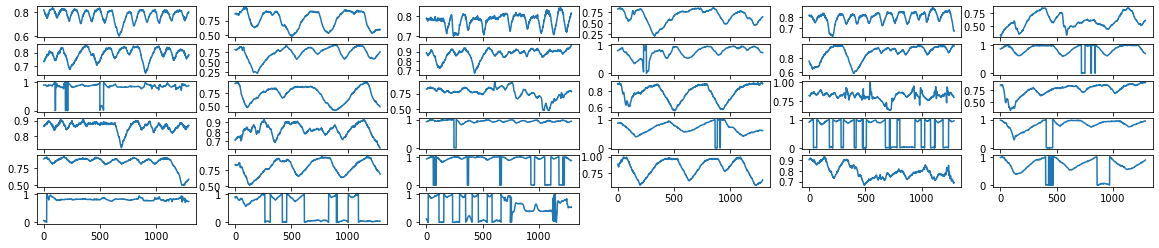

<Figure size 432x288 with 0 Axes>

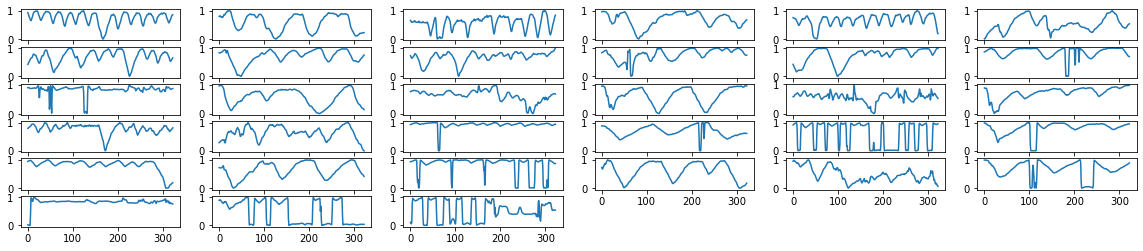

In [12]:
#plot n samples to compare the normalized data to the shortened data
n = 33

#plot some normalized data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])

#plot some shortened data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])

## Classifiers

#### Simple dense layer

Optimize hyperparameters with talos:

In [13]:
def Dense_classifier_optimization(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  metrics=['acc'])
    
    out = model.fit(x_train, y_train,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            verbose=0,
            validation_data=[x_val, y_val])

    return out, model

In [14]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh, binary_crossentropy

params = {
    'lr': (0.1, 10, 10),
    'dropout': (0, 0.40, 10),
    'optimizer': [Adam, Nadam],
    'hidden_size': [16,32,64,128,256],
    'loss': ['binary_crossentropy'],
    'last_activation': ['relu', 'sigmoid', 'softmax'],
    'activation': ['relu', 'sigmoid', 'softmax'],
    'batch_size': [64,128,256],
    'epochs': [100]
}

In [15]:
scan_object = talos.Scan(x_train,
                         y_train, 
                         params=params,
                         model=Dense_classifier_optimization,
                         experiment_name='contractive_ae_normalized_classif',
                         random_method='uniform_mersenne',
                         fraction_limit=.001)

  0%|                                                                                           | 0/27 [00:00<?, ?it/s]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


 48%|███████████████████████████████████████▍                                          | 13/27 [00:23<00:24,  1.77s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:48<00:00,  1.80s/it]


In [16]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
# analyze_object.data

In [17]:
analyze_object.table(['val_acc', 'acc'])[0:4]

,lr,val_loss,dropout,start,batch_size,val_acc,epochs,round_epochs,duration,activation,loss,loss,hidden_size,last_activation,end,acc,optimizer
0,9.01,0.725632,0.00,11/03/20-175749,64,0.595890,100,100,1.604036,sigmoid,0.497603,binary_crossentropy,32,sigmoid,11/03/20-175751,0.770588,<class 'tensorflow.python.keras.optimizer_v2.a...
17,5.05,0.687987,0.08,11/03/20-175822,128,0.589041,100,100,1.403417,softmax,0.565419,binary_crossentropy,64,sigmoid,11/03/20-175823,0.729412,<class 'tensorflow.python.keras.optimizer_v2.a...
16,4.06,0.759014,0.20,11/03/20-175820,128,0.561644,100,100,1.708913,sigmoid,0.512473,binary_crossentropy,256,sigmoid,11/03/20-175822,0.776471,<class 'tensorflow.python.keras.optimizer_v2.a...
10,1.09,0.722174,0.36,11/03/20-175808,64,0.554795,100,100,2.137170,relu,0.521870,binary_crossentropy,256,sigmoid,11/03/20-175810,0.729412,<class 'tensorflow.python.keras.optimizer_v2.a...


In [18]:
analyze_object.table(['val_acc', 'acc'])[0:1].to_dict('list')

{'lr': [9.01],
 'val_loss': [0.7256315995569098],
 'dropout': [0.0],
 'start': ['11/03/20-175749'],
 'batch_size': [64],
 'val_acc': [0.5958904027938843],
 'epochs': [100],
 'round_epochs': [100],
 'duration': [1.6040360927581787],
 'activation': ['sigmoid'],
 'loss': ['binary_crossentropy'],
 'hidden_size': [32],
 'last_activation': ['sigmoid'],
 'end': ['11/03/20-175751'],
 'acc': [0.770588219165802],
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam]}

#### LSTM-based classifier  
based on the original author's code

Optimize hyperparameters with talos:

In [19]:
def LSTM_classifier_optimization(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  metrics=['acc'])
    
    out = model.fit(x_train, y_train,
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            verbose=0,
            validation_data=[x_val, y_val])

    return out, model

Run the base classifier:

In [20]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh, binary_crossentropy

params = {
    'lr': (0.1, 10, 10),
    'kernel_size': [8,16,24,32,36,42,48],
    'filters': [4,8,16],
    'strides': [3,4],
    'pool_size': [2,3],
    'dropout': (0, 0.30, 10),
    'optimizer': [Adam, Nadam],
    'loss': ['binary_crossentropy'],
    'activation': ['relu'],
    'last_activation': ['relu', 'sigmoid'],
    'lstm_output_size': (96,256,8),
    'batch_size': [32,64,128],
    'epochs': [100]
}

In [21]:
# Reshape the data to fit the classifier
xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)

scan_object = talos.Scan(xt_train,
                         y_train, 
                         params=params,
                         model=LSTM_classifier_optimization,
                         experiment_name='contractive_ae_normalized_classif',
                         random_method='uniform_mersenne',
                         fraction_limit=.00003)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [05:05<00:00, 12.75s/it]


In [22]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)
# access the dataframe with the results
# analyze_object.data

In [23]:
analyze_object.table(['val_acc', 'acc'])[0:4]

,kernel_size,val_loss,strides,pool_size,filters,lstm_output_size,end,lr,acc,batch_size,...,loss,dropout,start,val_acc,duration,activation,optimizer,epochs,round_epochs,last_activation
4,32,0.690298,4,2,8,236,11/03/20-175943,0.10,0.750000,32,...,binary_crossentropy,0.09,11/03/20-175923,0.643836,19.882560,relu,<class 'tensorflow.python.keras.optimizer_v2.n...,100,100,sigmoid
21,36,0.763974,3,3,4,136,11/03/20-180312,5.05,0.641176,128,...,binary_crossentropy,0.09,11/03/20-180304,0.582192,7.882578,relu,<class 'tensorflow.python.keras.optimizer_v2.a...,100,100,relu
19,16,0.646020,3,3,4,156,11/03/20-180248,0.10,0.644118,32,...,binary_crossentropy,0.00,11/03/20-180235,0.568493,13.463157,relu,<class 'tensorflow.python.keras.optimizer_v2.n...,100,100,relu
0,48,0.699398,3,3,8,96,11/03/20-175847,1.09,0.473529,64,...,binary_crossentropy,0.24,11/03/20-175838,0.568493,9.333811,relu,<class 'tensorflow.python.keras.optimizer_v2.n...,100,100,relu


In [24]:
analyze_object.table(['val_acc', 'acc'])[0:1].to_dict('list')

{'kernel_size': [32],
 'val_loss': [0.6902977293484831],
 'strides': [4],
 'pool_size': [2],
 'filters': [8],
 'lstm_output_size': [236],
 'end': ['11/03/20-175943'],
 'lr': [0.1],
 'acc': [0.75],
 'batch_size': [32],
 'loss': ['binary_crossentropy'],
 'dropout': [0.09],
 'start': ['11/03/20-175923'],
 'val_acc': [0.6438356041908264],
 'duration': [19.88256025314331],
 'activation': ['relu'],
 'optimizer': [tensorflow.python.keras.optimizer_v2.nadam.Nadam],
 'epochs': [100],
 'round_epochs': [100],
 'last_activation': ['sigmoid']}

#### kNN

In [25]:
# Create the random grid
random_grid = {'n_neighbors': [3, 5, 7, 9, 11],
               'metric': ['cosine', 'manhattan', 'Euclidean', 'l1', 'l2', 'Minkowski'],
               'p': [3]}

In [26]:
from sklearn.neighbors import KNeighborsClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
knc = KNeighborsClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
knc_random = RandomizedSearchCV(estimator = knc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
knc_random.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'metric': ['cosine', 'manhattan',
                                                   'Euclidean', 'l1', 'l2',
                                                   'Minkowski'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [3]},
                   random_state=42, scoring='accuracy', verbose=2)

In [27]:
knc_random.best_params_

{'p': 3, 'n_neighbors': 7, 'metric': 'cosine'}

In [28]:
base_model = KNeighborsClassifier()
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

best_random = knc_random.best_estimator_
random_accuracy = np.sum(best_random.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(random_accuracy))

print('Improvement of {:0.2f}.'.format( (random_accuracy - base_accuracy)))

Accuracy = 0.47.
Accuracy = 0.64.
Improvement of 0.17.


####  SVC

In [29]:
# Create the random grid
random_grid = {'C': [1.0, 1.1, 1.5, 2.0],
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [30]:
from sklearn.svm import SVC
# Use the random grid to search for best hyperparameters
# First create the base model to tune
svc = SVC()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
svc_random.fit(x_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.1s finished


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [1.0, 1.1, 1.5, 2.0],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=2)

In [31]:
svc_random.best_params_

{'kernel': 'rbf', 'C': 1.5}

In [32]:
base_model = SVC(C=1, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

best_random = svc_random.best_estimator_
random_accuracy = np.sum(best_random.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(random_accuracy))

print('Improvement of {:0.2f}.'.format( (random_accuracy - base_accuracy)))

Accuracy = 0.53.
Accuracy = 0.58.
Improvement of 0.06.


#### Random Forest

In [33]:
# from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [34]:
from sklearn.ensemble import RandomForestClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.0s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [35]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [36]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

best_random = rf_random.best_estimator_
random_accuracy = np.sum(best_random.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(random_accuracy))

print('Improvement of {:0.2f}.'.format( (random_accuracy - base_accuracy)))

Accuracy = 0.61.
Accuracy = 0.67.
Improvement of 0.06.


#### Naive Bayesian

In [37]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB

base_model = GaussianNB()
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

base_model = BernoulliNB()
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

base_model = ComplementNB()
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

base_model = MultinomialNB()
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

Accuracy = 0.47.
Accuracy = 0.50.
Accuracy = 0.61.
Accuracy = 0.61.


#### XGBoost

In [38]:
# from https://medium.com/swlh/xgboost-hyperparameters-optimization-with-scikit-learn-to-rank-top-20-44ea528efa58
random_grid = {
    'n_estimators': np.array([80,83,85,90,100]),
}

In [39]:
from xgboost import XGBClassifier
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
xgb_random.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.2s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.4s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                          

In [40]:
xgb_random.best_params_

{'n_estimators': 83}

In [41]:
base_model = XGBClassifier(random_state=42)
base_model.fit(x_train, y_train)
base_accuracy = np.sum(base_model.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(base_accuracy))

best_random = xgb_random.best_estimator_
random_accuracy = np.sum(best_random.predict(x_test) == y_test.T) / y_test.shape[0]
print('Accuracy = {:0.2f}.'.format(random_accuracy))

print('Improvement of {:0.2f}.'.format( (random_accuracy - base_accuracy)))

Accuracy = 0.75.
Accuracy = 0.75.
Improvement of 0.00.
